In [56]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.dependencies import *

%matplotlib inline
warnings.filterwarnings("ignore")

In [21]:
DATA_INTER_PATH = os.path.join('..', 'data', 'interim')
DATA_PROCE_PATH = os.path.join('..', 'data', 'processed')
IMG_PATH = os.path.join('..','reports', 'figures')
DATA_INTER_NAME_2 = 'general_2.csv'
DATA_PROCE_NAME = 'processed.csv'

DATE_CHURN = pd.to_datetime('2018-08-01 00:00:00+00:00')

In [51]:
df_2 = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_NAME_2))

df_2['register_date'] = pd.to_datetime(df_2['register_date'])
df_2['last_purchase_date'] = pd.to_datetime(df_2['last_purchase_date'])
df_2.head(2)

,customer_code,register_date,total_price,group_code,segment_code,last_purchase_date,is_churn,item_total_price,discount
0,0,2008-09-23 00:00:00+00:00,4721.62,0,0,2018-06-08 00:00:00+00:00,0.0,5844.50,1
1,0,2009-05-06 00:00:00+00:00,2429.67,0,0,2018-06-08 00:00:00+00:00,0.0,2983.96,1


In [52]:
df_3 = df_2\
    .drop('discount', axis=1)\
    .groupby(
        by=[
            'customer_code', 
            'group_code', 
            'segment_code', 
            'is_churn'
        ], as_index=False)\
    .agg(
        {
            'register_date': 'max', 
            'total_price': 'sum',
            'item_total_price': 'sum',
            'last_purchase_date': 'max'
        }
)
(df_3['last_purchase_date'] == df_3['register_date']).unique()

array([ True])

In [53]:
df_3.is_churn.value_counts()

0.0    737
1.0     81
Name: is_churn, dtype: int64

In [57]:
df_3['discount'] = df_3.apply(lambda x: discount(x.item_total_price, x.total_price), axis=1)

In [59]:
df_3.discount.value_counts()

1    649
0    169
Name: discount, dtype: int64

In [60]:
df_3['qnt_days'] = DATE_CHURN - df_3.last_purchase_date
df_3['qnt_days'] = df_3.apply(lambda x: x['qnt_days'].days, axis=1)
df_3 = df_3[
    [
        'customer_code', 'group_code', 'segment_code', 
        'total_price', 'item_total_price', 'discount',
        'last_purchase_date', 'qnt_days', 'is_churn'
    ]
]

In [61]:
df_3.head(1)

,customer_code,group_code,segment_code,total_price,item_total_price,discount,last_purchase_date,qnt_days,is_churn
0,0,0,0,74215.11,84322.67,1,2018-06-08 00:00:00+00:00,54,0.0


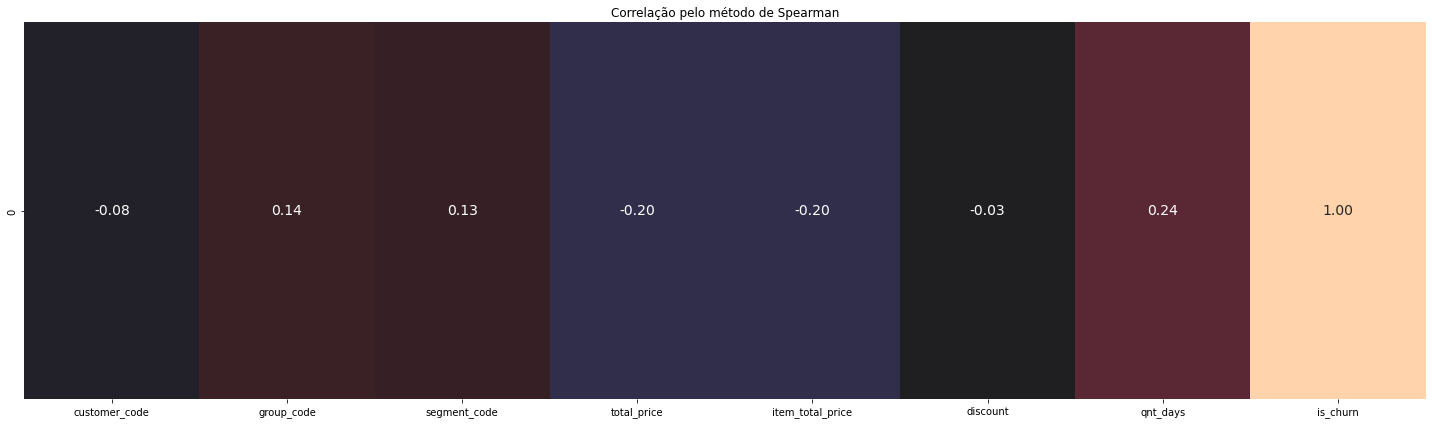

In [62]:
plt.figure(figsize=(20,6))
corrmat = df_3.corr(method='spearman')
sns.heatmap([corrmat['is_churn']], xticklabels = corrmat.index,
            annot=True, fmt='.2f', annot_kws={'size': 14},
            cbar=False, center=0)
plt.title('Correlação pelo método de Spearman')

plt.savefig(os.path.join(IMG_PATH,'corr-spearman.png'), format='png')
plt.tight_layout()
plt.show()

In [64]:
df_3.to_csv(os.path.join(DATA_PROCE_PATH, DATA_PROCE_NAME), index=False)

## Considerações

1. Todas as features foram mantidas.
2. A variável **discount** representa se o cliente teve algum tipo de desconto até **01 de Ago de 2018**;
3. A variável **qnt_days** represemta quantos dias desde a sua ultima compra até **01 de Ago de 2018**.